In [22]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [23]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [24]:
!wget https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py -O tf_keras_model.py

--2022-06-16 21:17:50--  https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6795 (6.6K) [text/plain]
Saving to: ‘tf_keras_model.py’

tf_keras_model.py   100%[===================>]   6.64K  --.-KB/s    in 0s      

2022-06-16 21:17:51 (64.6 MB/s) - ‘tf_keras_model.py’ saved [6795/6795]



In [56]:
!wget https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/lr_finder.py -O lr_finder.py

--2022-06-16 21:36:05--  https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/lr_finder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815 [text/plain]
Saving to: ‘lr_finder.py’

lr_finder.py        100%[===================>]     815  --.-KB/s    in 0s      

2022-06-16 21:36:05 (55.0 MB/s) - ‘lr_finder.py’ saved [815/815]



In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# VANNO TUTTI CAMBIATI

# !wget https://www.dropbox.com/s/6s5khncrval4rz9/bkg_et.npy?dl=1 -o bkg_et.npy
# !wget https://www.dropbox.com/s/qc7z1nhqh5xvpbg/bkg_mask.npy?dl=1 -o bkg_mask.npy
# !wget https://www.dropbox.com/s/fs5e9wuhqtr66xh/bkg_xy.npy?dl=1 -o bkg_xy.npy
# !wget https://www.dropbox.com/s/w0b94xzyk2wg7y4/signal_et.npy?dl=1 -o signal_et.npy
# !wget https://www.dropbox.com/s/3k6b0u3zz65xnyf/signal_mask.npy?dl=1 -o signal_mask.npy
# !wget https://www.dropbox.com/s/chcep3q8terrj4k/signal_xy.npy?dl=1 -o signal_xy.npy

In [60]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net_lite_custom, edge_conv
from lr_finder import LRFind

In [61]:
data_folder = "/content/drive/MyDrive/datiML"

name_map = {"points": "xy", "features": "et", "mask": "mask", "summary": "etrn"} # va provato sia xy che rphi

signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

In [62]:
S =  signal["mask"].shape[0] #entries segnale
F =    mnbs["mask"].shape[0] #entries mnbs (background flash da fascio)
C = cosmics["mask"].shape[0] #entries cosmici

N = S + F + C

p = np.random.permutation(N) #

In [63]:
'''
cluster su disco 0 in un injection cycle (1.33s):
RMC: 330
MNBS: 1.3M
cosmici: 4

cluster simulati su disco 0:
RMC: 150k
MNBS: 1.05M
cosmici: 53k

pesi:
RMC: 66/150k 
MNBS: 
Cosmici: 4/53k
'''

signal_weight = 330/150e3 * 100
mnbs_weight = 0.24 * 100
cosmics_weight = 4/53e3 * 100

'''
il campione MC è stato filtrato con ROOT
effettuando due tagli di preselezione:
E del cluster > 50 MeV  &&  R del centroide del cluster > 480 mm
'''

print(end="")

In [64]:
data = {key: np.concatenate( (signal[key], mnbs[key], cosmics[key]) )[p] for key in name_map}

label_list = [1, 0, 0]
entries_list = [S, F, C]
weight_list = [signal_weight, mnbs_weight, cosmics_weight]

print(f"- Entries per signale, mnbs e cosmici:{entries_list}")
print(f"- Pesi per signale, mnbs e cosmici:{weight_list}")

label = np.concatenate( 
    [ np.ones((e))*l for e, l in zip(entries_list,  label_list) ]
)[p]

sample_weight = np.concatenate( 
    [ np.ones((e))*w for e, w in zip(entries_list, weight_list) ]
)[p]

- Entries per signale, mnbs e cosmici:[41372, 1132, 41598]
- Pesi per signale, mnbs e cosmici:[0.22, 24.0, 0.007547169811320755]


In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for key in ["points", "features"]:
  data[key][data["mask"].reshape(N, 50)] = scaler.fit_transform(data[key][data["mask"].reshape(N, 50)])

data["summary"] = scaler.fit_transform(data["summary"])

In [66]:
train_data  = {key: data[key][int(N*0.0) : int(N*0.7)] for key in name_map}
test_data   = {key: data[key][int(N*0.7) : int(N*0.9)] for key in name_map}
val_data    = {key: data[key][int(N*0.9) : int(N*1.0)] for key in name_map}

train_label = label[int(N*0.0) : int(N*0.7)]
test_label  = label[int(N*0.7) : int(N*0.9)]
val_label   = label[int(N*0.9) : int(N*1.0)]

train_weight = sample_weight[int(N*0.0) : int(N*0.7)]
test_weight  = sample_weight[int(N*0.7) : int(N*0.9)]
val_weight   = sample_weight[int(N*0.9) : int(N*1.0)]

In [105]:
input_shapes = {'points': (50, 2), 'features': (50, 2), 'mask':(50, 1)}

model = get_particle_net_lite_custom(num_classes, input_shapes)

In [68]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 30

In [113]:
def lr_schedule(epoch):
    lr = 5e-2
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [114]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

[2022-06-16 21:55:53,991] INFO: Learning rate: 0.050000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 50, 1)]      0           []                               
                                                                                                  
 tf.math.not_equal_4 (TFOpLambd  (None, 50, 1)       0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_8 (TFOpLambda)         (None, 50, 1)        0           ['tf.math.not_equal_4[0][0]']    
                                                                                                  
 tf.math.equal_4 (TFOpLambda)   (None, 50, 1)        0           ['tf.cast_8[0][0]']    

In [115]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
'''
lr_finder_steps = 400
lr_find = LRFind(1e-6, 1e1, lr_finder_steps)
'''
callbacks = [checkpoint, progress_bar, lr_scheduler]

In [116]:
history = model.fit(
    [train_data["points"], train_data["features"], train_data["mask"], train_data["summary"]], 
    train_label,
    batch_size=batch_size,
    epochs=40,
    validation_data=(
      [val_data["points"], val_data["features"], val_data["mask"], val_data["summary"]], 
      val_label, val_weight
    ),
    shuffle=True,
    sample_weight=train_weight,
    callbacks=callbacks,
)


Epoch 1/40


[2022-06-16 21:56:07,825] INFO: Learning rate: 0.050000


      0/Unknown - 10s 0s/sample - loss: 0.1463 - accuracy: 0.7054 - precision_6: 0.7307 - recall_6: 0.6382
Epoch 1: val_accuracy improved from -inf to 0.82666, saving model to model_checkpoints/particle_net_lite_model.001.h5
58/58 [==============================] - 13s 230ms/sample - loss: 0.1463 - accuracy: 0.7054 - precision_6: 0.7307 - recall_6: 0.6382 - val_loss: 0.4511 - val_accuracy: 0.8267 - val_precision_6: 0.7876 - val_recall_6: 0.8776
Epoch 2/40


[2022-06-16 21:56:21,187] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.1260 - accuracy: 0.6637 - precision_6: 0.7311 - recall_6: 0.5041
Epoch 2: val_accuracy did not improve from 0.82666
58/58 [==============================] - 10s 167ms/sample - loss: 0.1260 - accuracy: 0.6637 - precision_6: 0.7311 - recall_6: 0.5041 - val_loss: 0.1460 - val_accuracy: 0.7552 - val_precision_6: 0.7663 - val_recall_6: 0.7091
Epoch 3/40


[2022-06-16 21:56:30,867] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.1085 - accuracy: 0.7218 - precision_6: 0.7663 - recall_6: 0.6278
Epoch 3: val_accuracy did not improve from 0.82666
58/58 [==============================] - 10s 168ms/sample - loss: 0.1085 - accuracy: 0.7218 - precision_6: 0.7663 - recall_6: 0.6278 - val_loss: 0.0947 - val_accuracy: 0.7465 - val_precision_6: 0.7937 - val_recall_6: 0.6416
Epoch 4/40


[2022-06-16 21:56:40,634] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.1062 - accuracy: 0.7426 - precision_6: 0.7949 - recall_6: 0.6450
Epoch 4: val_accuracy did not improve from 0.82666
58/58 [==============================] - 10s 166ms/sample - loss: 0.1062 - accuracy: 0.7426 - precision_6: 0.7949 - recall_6: 0.6450 - val_loss: 0.0870 - val_accuracy: 0.7532 - val_precision_6: 0.7968 - val_recall_6: 0.6559
Epoch 5/40


[2022-06-16 21:56:50,285] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.0977 - accuracy: 0.7678 - precision_6: 0.8078 - recall_6: 0.6949
Epoch 5: val_accuracy did not improve from 0.82666
58/58 [==============================] - 10s 164ms/sample - loss: 0.0977 - accuracy: 0.7678 - precision_6: 0.8078 - recall_6: 0.6949 - val_loss: 0.0813 - val_accuracy: 0.7793 - val_precision_6: 0.8209 - val_recall_6: 0.6943
Epoch 6/40


[2022-06-16 21:56:59,832] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.0982 - accuracy: 0.7758 - precision_6: 0.8253 - recall_6: 0.6922
Epoch 6: val_accuracy did not improve from 0.82666
58/58 [==============================] - 10s 166ms/sample - loss: 0.0982 - accuracy: 0.7758 - precision_6: 0.8253 - recall_6: 0.6922 - val_loss: 0.0895 - val_accuracy: 0.8095 - val_precision_6: 0.8302 - val_recall_6: 0.7611
Epoch 7/40


[2022-06-16 21:57:09,487] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.1004 - accuracy: 0.7755 - precision_6: 0.8303 - recall_6: 0.6851
Epoch 7: val_accuracy did not improve from 0.82666
58/58 [==============================] - 9s 163ms/sample - loss: 0.1004 - accuracy: 0.7755 - precision_6: 0.8303 - recall_6: 0.6851 - val_loss: 0.0884 - val_accuracy: 0.7583 - val_precision_6: 0.8145 - val_recall_6: 0.6466
Epoch 8/40


[2022-06-16 21:57:18,920] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.0992 - accuracy: 0.7790 - precision_6: 0.8355 - recall_6: 0.6876
Epoch 8: val_accuracy did not improve from 0.82666
58/58 [==============================] - 9s 162ms/sample - loss: 0.0992 - accuracy: 0.7790 - precision_6: 0.8355 - recall_6: 0.6876 - val_loss: 0.0809 - val_accuracy: 0.7825 - val_precision_6: 0.8253 - val_recall_6: 0.6970
Epoch 9/40


[2022-06-16 21:57:28,353] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.0935 - accuracy: 0.7792 - precision_6: 0.8385 - recall_6: 0.6845
Epoch 9: val_accuracy did not improve from 0.82666
58/58 [==============================] - 9s 163ms/sample - loss: 0.0935 - accuracy: 0.7792 - precision_6: 0.8385 - recall_6: 0.6845 - val_loss: 0.1079 - val_accuracy: 0.7692 - val_precision_6: 0.8314 - val_recall_6: 0.6547
Epoch 10/40


[2022-06-16 21:57:37,789] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.0977 - accuracy: 0.7855 - precision_6: 0.8451 - recall_6: 0.6923
Epoch 10: val_accuracy improved from 0.82666 to 0.82784, saving model to model_checkpoints/particle_net_lite_model.010.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0977 - accuracy: 0.7855 - precision_6: 0.8451 - recall_6: 0.6923 - val_loss: 0.0787 - val_accuracy: 0.8278 - val_precision_6: 0.8612 - val_recall_6: 0.7670
Epoch 11/40


[2022-06-16 21:57:47,385] INFO: Learning rate: 0.050000


 0/58 [..............................] - ETA: 0s - loss: 0.0863 - accuracy: 0.8070 - precision_6: 0.8616 - recall_6: 0.7256
Epoch 11: val_accuracy improved from 0.82784 to 0.87588, saving model to model_checkpoints/particle_net_lite_model.011.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0863 - accuracy: 0.8070 - precision_6: 0.8616 - recall_6: 0.7256 - val_loss: 0.1196 - val_accuracy: 0.8759 - val_precision_6: 0.8707 - val_recall_6: 0.8724
Epoch 12/40


[2022-06-16 21:57:57,020] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0796 - accuracy: 0.8322 - precision_6: 0.8718 - recall_6: 0.7737
Epoch 12: val_accuracy did not improve from 0.87588
58/58 [==============================] - 9s 164ms/sample - loss: 0.0796 - accuracy: 0.8322 - precision_6: 0.8718 - recall_6: 0.7737 - val_loss: 0.0666 - val_accuracy: 0.8603 - val_precision_6: 0.8779 - val_recall_6: 0.8254
Epoch 13/40


[2022-06-16 21:58:06,526] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0774 - accuracy: 0.8314 - precision_6: 0.8706 - recall_6: 0.7733
Epoch 13: val_accuracy did not improve from 0.87588
58/58 [==============================] - 9s 163ms/sample - loss: 0.0774 - accuracy: 0.8314 - precision_6: 0.8706 - recall_6: 0.7733 - val_loss: 0.0613 - val_accuracy: 0.8569 - val_precision_6: 0.8770 - val_recall_6: 0.8182
Epoch 14/40


[2022-06-16 21:58:15,999] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0779 - accuracy: 0.8345 - precision_6: 0.8732 - recall_6: 0.7776
Epoch 14: val_accuracy did not improve from 0.87588
58/58 [==============================] - 9s 163ms/sample - loss: 0.0779 - accuracy: 0.8345 - precision_6: 0.8732 - recall_6: 0.7776 - val_loss: 0.0630 - val_accuracy: 0.8369 - val_precision_6: 0.8771 - val_recall_6: 0.7700
Epoch 15/40


[2022-06-16 21:58:25,447] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0787 - accuracy: 0.8344 - precision_6: 0.8719 - recall_6: 0.7788
Epoch 15: val_accuracy did not improve from 0.87588
58/58 [==============================] - 9s 162ms/sample - loss: 0.0787 - accuracy: 0.8344 - precision_6: 0.8719 - recall_6: 0.7788 - val_loss: 0.0601 - val_accuracy: 0.8614 - val_precision_6: 0.8784 - val_recall_6: 0.8273
Epoch 16/40


[2022-06-16 21:58:34,878] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0755 - accuracy: 0.8416 - precision_6: 0.8770 - recall_6: 0.7898
Epoch 16: val_accuracy did not improve from 0.87588
58/58 [==============================] - 9s 163ms/sample - loss: 0.0755 - accuracy: 0.8416 - precision_6: 0.8770 - recall_6: 0.7898 - val_loss: 0.0586 - val_accuracy: 0.8532 - val_precision_6: 0.8788 - val_recall_6: 0.8071
Epoch 17/40


[2022-06-16 21:58:44,349] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0708 - accuracy: 0.8430 - precision_6: 0.8732 - recall_6: 0.7977
Epoch 17: val_accuracy did not improve from 0.87588
58/58 [==============================] - 9s 164ms/sample - loss: 0.0708 - accuracy: 0.8430 - precision_6: 0.8732 - recall_6: 0.7977 - val_loss: 0.0578 - val_accuracy: 0.8515 - val_precision_6: 0.8751 - val_recall_6: 0.8076
Epoch 18/40


[2022-06-16 21:58:53,851] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0746 - accuracy: 0.8443 - precision_6: 0.8737 - recall_6: 0.8002
Epoch 18: val_accuracy did not improve from 0.87588
58/58 [==============================] - 9s 164ms/sample - loss: 0.0746 - accuracy: 0.8443 - precision_6: 0.8737 - recall_6: 0.8002 - val_loss: 0.0574 - val_accuracy: 0.8541 - val_precision_6: 0.8827 - val_recall_6: 0.8047
Epoch 19/40


[2022-06-16 21:59:03,363] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0734 - accuracy: 0.8424 - precision_6: 0.8780 - recall_6: 0.7905
Epoch 19: val_accuracy did not improve from 0.87588
58/58 [==============================] - 10s 164ms/sample - loss: 0.0734 - accuracy: 0.8424 - precision_6: 0.8780 - recall_6: 0.7905 - val_loss: 0.0558 - val_accuracy: 0.8628 - val_precision_6: 0.8796 - val_recall_6: 0.8293
Epoch 20/40


[2022-06-16 21:59:12,889] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0719 - accuracy: 0.8486 - precision_6: 0.8775 - recall_6: 0.8055
Epoch 20: val_accuracy did not improve from 0.87588
58/58 [==============================] - 10s 164ms/sample - loss: 0.0719 - accuracy: 0.8486 - precision_6: 0.8775 - recall_6: 0.8055 - val_loss: 0.0562 - val_accuracy: 0.8579 - val_precision_6: 0.8793 - val_recall_6: 0.8180
Epoch 21/40


[2022-06-16 21:59:22,405] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0705 - accuracy: 0.8441 - precision_6: 0.8773 - recall_6: 0.7953
Epoch 21: val_accuracy did not improve from 0.87588
58/58 [==============================] - 10s 164ms/sample - loss: 0.0705 - accuracy: 0.8441 - precision_6: 0.8773 - recall_6: 0.7953 - val_loss: 0.0546 - val_accuracy: 0.8641 - val_precision_6: 0.8839 - val_recall_6: 0.8271
Epoch 22/40


[2022-06-16 21:59:31,932] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0707 - accuracy: 0.8561 - precision_6: 0.8802 - recall_6: 0.8200
Epoch 22: val_accuracy did not improve from 0.87588
58/58 [==============================] - 10s 164ms/sample - loss: 0.0707 - accuracy: 0.8561 - precision_6: 0.8802 - recall_6: 0.8200 - val_loss: 0.0573 - val_accuracy: 0.8605 - val_precision_6: 0.8875 - val_recall_6: 0.8143
Epoch 23/40


[2022-06-16 21:59:41,481] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0714 - accuracy: 0.8519 - precision_6: 0.8811 - recall_6: 0.8092
Epoch 23: val_accuracy did not improve from 0.87588
58/58 [==============================] - 10s 164ms/sample - loss: 0.0714 - accuracy: 0.8519 - precision_6: 0.8811 - recall_6: 0.8092 - val_loss: 0.0540 - val_accuracy: 0.8680 - val_precision_6: 0.8837 - val_recall_6: 0.8367
Epoch 24/40


[2022-06-16 21:59:51,010] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0707 - accuracy: 0.8510 - precision_6: 0.8780 - recall_6: 0.8108
Epoch 24: val_accuracy did not improve from 0.87588
58/58 [==============================] - 10s 164ms/sample - loss: 0.0707 - accuracy: 0.8510 - precision_6: 0.8780 - recall_6: 0.8108 - val_loss: 0.0531 - val_accuracy: 0.8690 - val_precision_6: 0.8834 - val_recall_6: 0.8394
Epoch 25/40


[2022-06-16 22:00:00,556] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0665 - accuracy: 0.8532 - precision_6: 0.8799 - recall_6: 0.8136
Epoch 25: val_accuracy improved from 0.87588 to 0.88016, saving model to model_checkpoints/particle_net_lite_model.025.h5
58/58 [==============================] - 10s 169ms/sample - loss: 0.0665 - accuracy: 0.8532 - precision_6: 0.8799 - recall_6: 0.8136 - val_loss: 0.0536 - val_accuracy: 0.8802 - val_precision_6: 0.8863 - val_recall_6: 0.8623
Epoch 26/40


[2022-06-16 22:00:10,367] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0678 - accuracy: 0.8570 - precision_6: 0.8820 - recall_6: 0.8201
Epoch 26: val_accuracy improved from 0.88016 to 0.88301, saving model to model_checkpoints/particle_net_lite_model.026.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0678 - accuracy: 0.8570 - precision_6: 0.8820 - recall_6: 0.8201 - val_loss: 0.0516 - val_accuracy: 0.8830 - val_precision_6: 0.8849 - val_recall_6: 0.8709
Epoch 27/40


[2022-06-16 22:00:19,995] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0699 - accuracy: 0.8525 - precision_6: 0.8811 - recall_6: 0.8105
Epoch 27: val_accuracy did not improve from 0.88301
58/58 [==============================] - 10s 164ms/sample - loss: 0.0699 - accuracy: 0.8525 - precision_6: 0.8811 - recall_6: 0.8105 - val_loss: 0.0518 - val_accuracy: 0.8780 - val_precision_6: 0.8848 - val_recall_6: 0.8591
Epoch 28/40


[2022-06-16 22:00:29,508] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0661 - accuracy: 0.8590 - precision_6: 0.8811 - recall_6: 0.8257
Epoch 28: val_accuracy did not improve from 0.88301
58/58 [==============================] - 10s 164ms/sample - loss: 0.0661 - accuracy: 0.8590 - precision_6: 0.8811 - recall_6: 0.8257 - val_loss: 0.0534 - val_accuracy: 0.8591 - val_precision_6: 0.8830 - val_recall_6: 0.8163
Epoch 29/40


[2022-06-16 22:00:39,022] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0661 - accuracy: 0.8580 - precision_6: 0.8851 - recall_6: 0.8187
Epoch 29: val_accuracy did not improve from 0.88301
58/58 [==============================] - 10s 164ms/sample - loss: 0.0661 - accuracy: 0.8580 - precision_6: 0.8851 - recall_6: 0.8187 - val_loss: 0.0511 - val_accuracy: 0.8701 - val_precision_6: 0.8850 - val_recall_6: 0.8399
Epoch 30/40


[2022-06-16 22:00:48,543] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0650 - accuracy: 0.8581 - precision_6: 0.8844 - recall_6: 0.8197
Epoch 30: val_accuracy improved from 0.88301 to 0.88979, saving model to model_checkpoints/particle_net_lite_model.030.h5
58/58 [==============================] - 10s 167ms/sample - loss: 0.0650 - accuracy: 0.8581 - precision_6: 0.8844 - recall_6: 0.8197 - val_loss: 0.0522 - val_accuracy: 0.8898 - val_precision_6: 0.8921 - val_recall_6: 0.8778
Epoch 31/40


[2022-06-16 22:00:58,211] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0640 - accuracy: 0.8684 - precision_6: 0.8869 - recall_6: 0.8406
Epoch 31: val_accuracy did not improve from 0.88979
58/58 [==============================] - 9s 164ms/sample - loss: 0.0640 - accuracy: 0.8684 - precision_6: 0.8869 - recall_6: 0.8406 - val_loss: 0.0494 - val_accuracy: 0.8746 - val_precision_6: 0.8881 - val_recall_6: 0.8468
Epoch 32/40


[2022-06-16 22:01:07,707] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0676 - accuracy: 0.8528 - precision_6: 0.8833 - recall_6: 0.8087
Epoch 32: val_accuracy did not improve from 0.88979
58/58 [==============================] - 10s 164ms/sample - loss: 0.0676 - accuracy: 0.8528 - precision_6: 0.8833 - recall_6: 0.8087 - val_loss: 0.0507 - val_accuracy: 0.8710 - val_precision_6: 0.8847 - val_recall_6: 0.8426
Epoch 33/40


[2022-06-16 22:01:17,226] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0632 - accuracy: 0.8649 - precision_6: 0.8858 - recall_6: 0.8338
Epoch 33: val_accuracy did not improve from 0.88979
58/58 [==============================] - 9s 164ms/sample - loss: 0.0632 - accuracy: 0.8649 - precision_6: 0.8858 - recall_6: 0.8338 - val_loss: 0.0489 - val_accuracy: 0.8800 - val_precision_6: 0.8905 - val_recall_6: 0.8569
Epoch 34/40


[2022-06-16 22:01:26,723] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0653 - accuracy: 0.8626 - precision_6: 0.8860 - recall_6: 0.8281
Epoch 34: val_accuracy did not improve from 0.88979
58/58 [==============================] - 10s 166ms/sample - loss: 0.0653 - accuracy: 0.8626 - precision_6: 0.8860 - recall_6: 0.8281 - val_loss: 0.0500 - val_accuracy: 0.8885 - val_precision_6: 0.8906 - val_recall_6: 0.8766
Epoch 35/40


[2022-06-16 22:01:36,384] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0622 - accuracy: 0.8680 - precision_6: 0.8865 - recall_6: 0.8401
Epoch 35: val_accuracy did not improve from 0.88979
58/58 [==============================] - 10s 165ms/sample - loss: 0.0622 - accuracy: 0.8680 - precision_6: 0.8865 - recall_6: 0.8401 - val_loss: 0.0489 - val_accuracy: 0.8831 - val_precision_6: 0.8870 - val_recall_6: 0.8685
Epoch 36/40


[2022-06-16 22:01:45,952] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0618 - accuracy: 0.8717 - precision_6: 0.8910 - recall_6: 0.8431
Epoch 36: val_accuracy did not improve from 0.88979
58/58 [==============================] - 9s 164ms/sample - loss: 0.0618 - accuracy: 0.8717 - precision_6: 0.8910 - recall_6: 0.8431 - val_loss: 0.0539 - val_accuracy: 0.8618 - val_precision_6: 0.8910 - val_recall_6: 0.8133
Epoch 37/40


[2022-06-16 22:01:55,455] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0601 - accuracy: 0.8706 - precision_6: 0.8875 - recall_6: 0.8449
Epoch 37: val_accuracy did not improve from 0.88979
58/58 [==============================] - 9s 163ms/sample - loss: 0.0601 - accuracy: 0.8706 - precision_6: 0.8875 - recall_6: 0.8449 - val_loss: 0.0505 - val_accuracy: 0.8750 - val_precision_6: 0.8923 - val_recall_6: 0.8429
Epoch 38/40


[2022-06-16 22:02:04,941] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0643 - accuracy: 0.8649 - precision_6: 0.8898 - recall_6: 0.8289
Epoch 38: val_accuracy did not improve from 0.88979
58/58 [==============================] - 10s 166ms/sample - loss: 0.0643 - accuracy: 0.8649 - precision_6: 0.8898 - recall_6: 0.8289 - val_loss: 0.0494 - val_accuracy: 0.8865 - val_precision_6: 0.8914 - val_recall_6: 0.8709
Epoch 39/40


[2022-06-16 22:02:14,562] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0614 - accuracy: 0.8703 - precision_6: 0.8912 - recall_6: 0.8396
Epoch 39: val_accuracy did not improve from 0.88979
58/58 [==============================] - 10s 165ms/sample - loss: 0.0614 - accuracy: 0.8703 - precision_6: 0.8912 - recall_6: 0.8396 - val_loss: 0.0489 - val_accuracy: 0.8774 - val_precision_6: 0.8921 - val_recall_6: 0.8488
Epoch 40/40


[2022-06-16 22:02:24,135] INFO: Learning rate: 0.005000


 0/58 [..............................] - ETA: 0s - loss: 0.0594 - accuracy: 0.8740 - precision_6: 0.8902 - recall_6: 0.8495
Epoch 40: val_accuracy did not improve from 0.88979
58/58 [==============================] - 10s 169ms/sample - loss: 0.0594 - accuracy: 0.8740 - precision_6: 0.8902 - recall_6: 0.8495 - val_loss: 0.0493 - val_accuracy: 0.8838 - val_precision_6: 0.9011 - val_recall_6: 0.8530


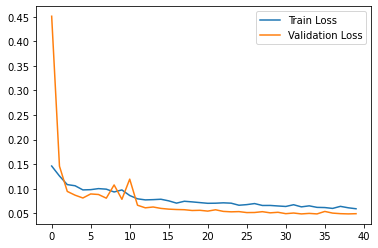

In [117]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

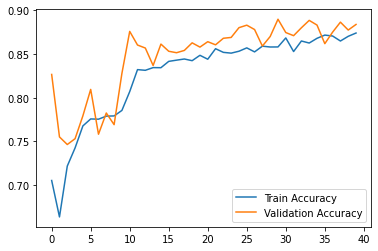

In [118]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()

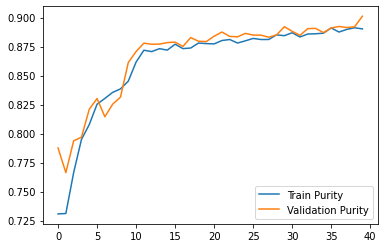

In [119]:
plt.plot(history.history['precision_6'], label="Train Purity")
plt.plot(history.history['val_precision_6'], label="Validation Purity")
plt.legend()

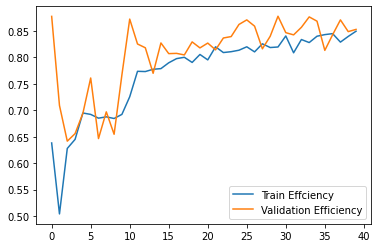

In [120]:
plt.plot(history.history['recall_6'], label="Train Effciency")
plt.plot(history.history['val_recall_6'], label="Validation Efficiency")
plt.legend()

In [101]:
!ls -1rt model_checkpoints/*model*.h5 | tail -n 1
!cp $(ls -1rt model_checkpoints/*model*.h5 | tail -n 1) model_checkpoints/last.h5

model_checkpoints/particle_net_lite_model.033.h5


In [121]:
model.load_weights("model_checkpoints/particle_net_lite_model.026.h5")

In [122]:
probs = model.predict_on_batch(test_data)

0.9668040752580238


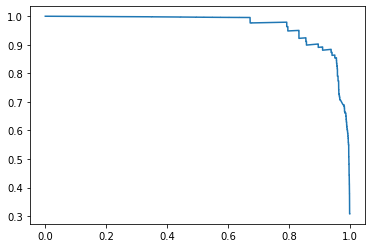

In [123]:
precision, recall, thresholds = precision_recall_curve(test_label, probs, sample_weight=test_weight)
plt.plot(recall, precision)
print(auc(recall, precision))